In [1]:
!pip uninstall -y triton torch torchvision torchaudio
!pip install -U pip
# torchvision z oficjalnego repo (CUDA 12.1)
!pip install "torch==2.4.1+cu121" "torchvision==0.19.1+cu121" --index-url https://download.pytorch.org/whl/cu121
!pip install -U onnx onnxruntime-gpu onnxruntime-tools

Found existing installation: triton 3.5.0
Uninstalling triton-3.5.0:
  Successfully uninstalled triton-3.5.0
Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.8.5 requires torch<2.10,>=1.10, which is not installed.
fastai 2.8.5 requires t

In [2]:
!pip install -U onnx onnxruntime-gpu onnxruntime-tools

In [3]:
!pip install -U pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 21.0 MB/s  0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [4]:
import torch, torchvision, onnx, onnxruntime
from onnxruntime.quantization import quantize_dynamic

## Przygotowanie danych i pętla treningowa
Dataset: Wykorzystujemy CIFAR-10 - standardowy zbiór obrazów (10 klas)

Transformacje: Obrazy są skalowane do rozmiaru 224 x 224 (standard dla wielu architektur CNN) i zamieniane na tensory.

train_model: pętla uczenia nadzorowanego z funkcją kosztu CrossEntropy i optymalizatorem Adam. Funkcja zwraca wytrenowany model i zapisuje jego wagi (.pth)

In [5]:
import time
from pathlib import Path
from typing import Dict, Callable, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_ROOT = "./data"
MODELS_DIR = Path("models")
ONNX_DIR = Path("onnx")
ONNX_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

def get_dataloaders(batch_size: int = 64) -> Tuple[DataLoader, DataLoader]:
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    train_ds = datasets.CIFAR10(DATA_ROOT, train=True, download=True, transform=transform)
    test_ds = datasets.CIFAR10(DATA_ROOT, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, test_loader

def train_model(model: nn.Module,
                train_loader: DataLoader,
                test_loader: DataLoader,
                epochs: int = 3,
                lr: float = 1e-3,
                name: str = "model") -> Dict:
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        acc = evaluate(model, test_loader)
        print(f"[{name}] epoch {epoch+1}/{epochs}, loss={train_loss:.4f}, acc={acc:.3f}")

    torch.save(model.state_dict(), MODELS_DIR / f"{name}.pth")
    return {"accuracy": acc, "loss": train_loss}


def evaluate(model: nn.Module, loader: DataLoader) -> float:
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total


## Definicja architektur modeli

Wybieramy trzy zróżnicowane architektury sieci neuronowych, aby sprawdzić, jak konwerter ONNX radzi sobie z różną złożonością obliczeniową

1. MobileNetV3 Small: Lekka sieć zaprojektowana na urządzenia mobilne/embedded (mało parametrów, niska latencja).

2. AlexNet: Klasyczna, prosta architektura, ale o dużej liczbie parametrów w warstwach gęstych.

3. ResNet18: Nowoczesna architektura - dobry kompromis między skutecznością a szybkością.

In [6]:
from torchvision.models import alexnet, resnet18, mobilenet_v3_small

NUM_CLASSES = 10  # dopasowane do CIFAR-10

from typing import Callable, Dict

def create_models() -> Dict[str, Callable[[], nn.Module]]:
    return {
        "mobilenet_v3_small": lambda: mobilenet_v3_small(num_classes=NUM_CLASSES),
        "alexnet": lambda: alexnet(num_classes=NUM_CLASSES),
        "resnet18": lambda: resnet18(num_classes=NUM_CLASSES),
    }



## Eksport do formatu ONNX

Używamy torch.onnx.export, która wykonuje tzw. tracing (śledzenie). Podajemy przykładowy "dummy input", a eksporter przepuszcza go przez sieć, rejestrując operacje matematyczne.

Plik .onnx, który jest grafową reprezentacją modelu, niezależną od frameworka PyTorch
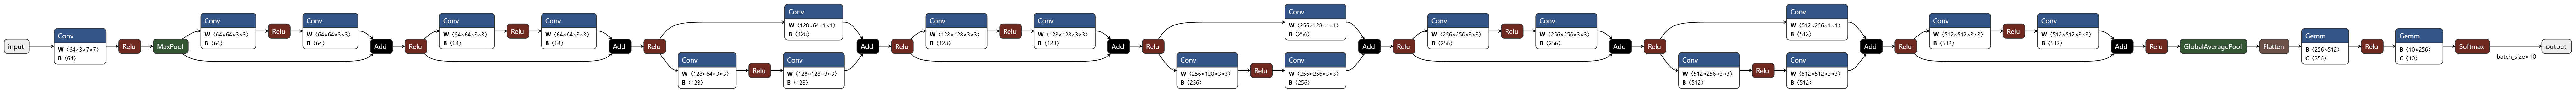

In [7]:
import onnx

def export_to_onnx(model_creator, weights_path, onnx_path, input_shape=(1, 3, 224, 224)):
    import onnx
    model = model_creator().to("cpu")
    state = torch.load(weights_path, map_location="cpu")
    model.load_state_dict(state)
    model.eval()

    dummy = torch.randn(*input_shape, device="cpu")

    torch.onnx.export(
        model,
        dummy,
        onnx_path.as_posix(),
        input_names=["input"],
        output_names=["logits"],
        opset_version=18,
    )

    onnx_model = onnx.load(onnx_path.as_posix())
    onnx.checker.check_model(onnx_model)
    print(f"Zapisano ONNX: {onnx_path}")



## Weryfikacja spójności numerycznej
Zanim przejdziemy do testów wydajności, musimy upewnić się, że model po konwersji działa identycznie jak oryginał.

Przepuszczamy ten sam losowy tensor przez model PyTorch oraz sesję ONNX Runtime. Obliczamy maksymalną różnicę absolutną (Max Abs Diff) między wynikami (logitami). Oczekujemy wartości bliskich zera (np. rzędu $10^{-5}$), wynikających z różnic w zaokrągleniach zmiennoprzecinkowych. Sprawdzamy też, czy predykcja klasy (Top-1) jest taka sama.

In [8]:
import numpy as np
import onnxruntime as ort

def compare_pytorch_onnx(model_creator: Callable[[], nn.Module],
                         weights_path: Path,
                         onnx_path: Path,
                         input_shape=(1, 3, 224, 224),
                         runs: int = 50):
    # jeden przykładowy batch
    x = torch.randn(*input_shape)
    x_cpu = x.clone()
    x = x.to(DEVICE)

    # wyjście z pytorcha
    model = model_creator().to(DEVICE)
    state = torch.load(weights_path, map_location=DEVICE)
    model.load_state_dict(state)
    model.eval()
    with torch.no_grad():
        y_torch = model(x).cpu()

    # wyjście z onnxa
    sess = ort.InferenceSession(onnx_path.as_posix(),
                                providers=["CPUExecutionProvider"])
    ort_inputs = {"input": x_cpu.numpy()}
    y_onnx = sess.run(None, ort_inputs)[0]
    y_onnx = torch.from_numpy(y_onnx)

    max_abs_diff = (y_torch - y_onnx).abs().max().item()
    same_top1 = (y_torch.argmax(dim=1) == y_onnx.argmax(dim=1)).item()

    print(f"Max |PT-ONNX| = {max_abs_diff:.6f}, top1 zgodny: {bool(same_top1)}")

    return max_abs_diff, bool(same_top1)


## Główny cel projektu - porównanie czasu wnioskowania

Mierzymy średni czas przetworzenia jednego batcha danych przez model PyTorch oraz ONNX Runtime.

Wykonujemy rundę rozgrzewkową (warm-up), aby ustabilizować GPU/CPU i bufory pamięci, a następnie mierzymy czas dla serii uruchomień, aby uzyskać wiarygodną średnią.

In [9]:
def benchmark_pytorch(model_creator, weights_path, input_shape=(1, 3, 224, 224), runs=100):
    model = model_creator().to(DEVICE)
    model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
    model.eval()
    x = torch.randn(*input_shape, device=DEVICE)

    with torch.no_grad():
        for _ in range(10):
            _ = model(x)

    start = time.time()
    with torch.no_grad():
        for _ in range(runs):
            _ = model(x)
    end = time.time()
    return (end - start) / runs


def benchmark_onnx(onnx_path, input_shape=(1, 3, 224, 224), runs=100):
    sess = ort.InferenceSession(onnx_path.as_posix(),
                                providers=["CPUExecutionProvider"])
    x = np.random.randn(*input_shape).astype(np.float32)

    for _ in range(10):
        _ = sess.run(None, {"input": x})

    start = time.time()
    for _ in range(runs):
        _ = sess.run(None, {"input": x})
    end = time.time()
    return (end - start) / runs


## Kwantyzacja dynamiczna

Próba optymalizacji modelu poprzez zmianę precyzji wag z liczb zmiennoprzecinkowych 32-bitowych (FP32) na liczby całkowite 8-bitowe (INT8).

Zmniejszenie rozmiaru modelu (nawet 4-krotnie) i potencjalne przyspieszenie wnioskowania na CPU.

Wykorzystujemy funkcje onnxruntime.quantization do wykonania kwantyzacji dynamicznej na wyeksportowanym wcześniej modelu.

In [10]:
from onnxruntime.quantization import quantize_dynamic, QuantType
from onnxruntime.quantization import shape_inference

def quantize_onnx(onnx_path: Path, quantized_path: Path):
    # pre-processing
    preprocessed_path = onnx_path.with_name(onnx_path.stem + "_pre.onnx")

    shape_inference.quant_pre_process(
        input_model_path=onnx_path.as_posix(),
        output_model_path=preprocessed_path.as_posix(),
        skip_optimization=False,
        skip_onnx_shape=False,
        skip_symbolic_shape=False,
        auto_merge=True,
    )

    quantize_dynamic(
        model_input=preprocessed_path.as_posix(),
        model_output=quantized_path.as_posix(),
        weight_type=QuantType.QInt8
    )

    print(f"Zapisano model skwantyzowany: {quantized_path}")

In [11]:
def file_size_mb(path: Path) -> float:
    return path.stat().st_size / (1024 ** 2)


In [12]:
!pip install onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.0/683.0 kB 14.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [onnxscript]


## Pipeline
Dla każdego modelu zdefiniowanego w słowniku models:

- Inicjalizuje nową instancję sieci.

- Uruchamia proces uczenia (train_model) przez zadaną liczbę epok.

- Eksportuje wytrenowane wagi do formatu ONNX.

- Weryfikuje poprawność konwersji (porównanie wyjść).

- Mierzy czasy wnioskowania dla PyTorch i ONNX.

Kwantyzacja: W drugiej części funkcji wybierany jest jeden model (resnet18) do eksperymentu z kompresją (kwantyzacją do INT8), aby sprawdzić zysk na rozmiarze i czasie działania.

In [13]:
from pprint import pprint

def main():
    train_loader, test_loader = get_dataloaders()

    models = create_models()
    summary = []

    for name, make_model in models.items():
        print(f"\n==== {name} ====")

        model = make_model()
        stats = train_model(model, train_loader, test_loader, epochs=5, name=name)

        weights_path = MODELS_DIR / f"{name}.pth"
        onnx_path = ONNX_DIR / f"{name}.onnx"

        export_to_onnx(make_model, weights_path, onnx_path)
        diff, same_top1 = compare_pytorch_onnx(make_model, weights_path, onnx_path)
        pt_time = benchmark_pytorch(make_model, weights_path)
        onnx_time = benchmark_onnx(onnx_path)

        row = {
            "model": name,
            "acc": stats["accuracy"],
            "pt_time_ms": pt_time * 1000,
            "onnx_time_ms": onnx_time * 1000,
            "max_diff": diff,
            "top1_equal": same_top1,
            "onnx_size_mb": file_size_mb(onnx_path),
        }
        summary.append(row)

    # kwantyzacja jednego modelu
    chosen = "resnet18"
    base_onnx = ONNX_DIR / f"{chosen}.onnx"
    q_onnx = ONNX_DIR / f"{chosen}_int8.onnx"

    try:
      quantize_onnx(base_onnx, q_onnx)
    except Exception as e:
      print("Kwantyzacja się wywaliła:", e)
    return


    onnx_time = benchmark_onnx(base_onnx)
    q_time = benchmark_onnx(q_onnx)
    size_f = file_size_mb(base_onnx)
    size_q = file_size_mb(q_onnx)

    print(f"\n=== Kwantyzacja modelu {chosen} ===")
    print(f"Rozmiar: float32={size_f:.2f}MB, int8={size_q:.2f}MB")
    print(f"Czas: ONNX={onnx_time*1000:.2f}ms, INT8={q_time*1000:.2f}ms")

    print("\n=== Podsumowanie modeli ===")
    pprint(summary)


if __name__ == "__main__":
    main()


100%|██████████| 170498071/170498071 [00:02<00:00, 70016253.87it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified

==== mobilenet_v3_small ====
[mobilenet_v3_small] epoch 1/5, loss=1.3406, acc=0.567
[mobilenet_v3_small] epoch 2/5, loss=0.8413, acc=0.683
[mobilenet_v3_small] epoch 3/5, loss=0.6475, acc=0.728
[mobilenet_v3_small] epoch 4/5, loss=0.5333, acc=0.802
[mobilenet_v3_small] epoch 5/5, loss=0.4562, acc=0.801


/tmp/ipython-input-731047009.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(weights_path, map_location="cpu")


Zapisano ONNX: onnx/mobilenet_v3_small.onnx
Max |PT-ONNX| = 0.000018, top1 zgodny: True


/tmp/ipython-input-616357764.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(weights_path, map_location=DEVICE)
/tmp/ipython-input-1318699619.py:3: F


==== alexnet ====
[alexnet] epoch 1/5, loss=2.3039, acc=0.100
[alexnet] epoch 2/5, loss=2.3028, acc=0.100
[alexnet] epoch 3/5, loss=2.3028, acc=0.100
[alexnet] epoch 4/5, loss=2.3028, acc=0.100
[alexnet] epoch 5/5, loss=2.3027, acc=0.100
Zapisano ONNX: onnx/alexnet.onnx
Max |PT-ONNX| = 0.000000, top1 zgodny: True

==== resnet18 ====
[resnet18] epoch 1/5, loss=1.3443, acc=0.628
[resnet18] epoch 2/5, loss=0.8145, acc=0.729
[resnet18] epoch 3/5, loss=0.6126, acc=0.773
[resnet18] epoch 4/5, loss=0.4914, acc=0.799
[resnet18] epoch 5/5, loss=0.3866, acc=0.823
Zapisano ONNX: onnx/resnet18.onnx
Max |PT-ONNX| = 0.000002, top1 zgodny: True
Zapisano model skwantyzowany: onnx/resnet18_int8.onnx


## Ocena wpływu kwantyzacji

Bezpośrednie porównanie modelu oryginalnego (FP32) z modelem skwantyzowanym (INT8).

- Obliczamy, o ile procent zmniejszył się plik na dysku
 - Porównujemy czasy wnioskowania. Na CPU operacje na liczbach całkowitych (INT8) są zazwyczaj szybsze niż na zmiennoprzecinkowych
- Sprawdzamy, jak bardzo spadła skuteczność klasyfikacji. Akceptowalny spadek to zazwyczaj poniżej 1% (0.01)
resnet18_int8.onnx.png

In [14]:
# @title
def run_quantization_experiment(model_name: str = "resnet18"):

    base_onnx = ONNX_DIR / f"{model_name}.onnx"
    q_onnx = ONNX_DIR / f"{model_name}_int8.onnx"

    if not base_onnx.exists():
        print(f"[BŁĄD] Nie znaleziono modelu bazowego: {base_onnx}")
        return

    if not q_onnx.exists():
        print(f"[BŁĄD] Nie znaleziono modelu zkwantyzowanego: {q_onnx}")
        return

    _, test_loader = get_dataloaders(batch_size=64)

    # print(f"Rozpoczynam kwantyzację modelu {base_onnx.name}...")
    # try:
    #     quantize_onnx(base_onnx, q_onnx)
    # except Exception as e:
    #     print(f"[BŁĄD] Kwantyzacja zakończona niepowodzeniem: {e}")
    #     return

    print("Zbieranie metryk wydajności...")
    size_fp32 = file_size_mb(base_onnx)
    size_int8 = file_size_mb(q_onnx)
    reduction = (size_fp32 - size_int8) / size_fp32 * 100

    time_fp32 = benchmark_onnx(base_onnx)
    time_int8 = benchmark_onnx(q_onnx)
    speedup = time_fp32 / time_int8

    print("Obliczanie dokładności")
    acc_fp32 = accuracy_onnx(base_onnx, test_loader)
    acc_int8 = accuracy_onnx(q_onnx, test_loader)
    acc_diff = acc_fp32 - acc_int8

    print(f"\nRAPORT KOŃCOWY: {model_name}")
    print(f"{'-'*85}")
    print(f"{'Metryka':<25} | {'FP32 (Original)':<18} | {'INT8 (Quantized)':<18} | {'Różnica':<15}")
    print(f"{'-'*85}")
    print(f"{'Rozmiar (MB)':<25} | {size_fp32:<18.2f} | {size_int8:<18.2f} | -{reduction:.1f}%")
    print(f"{'Czas inferencji (ms)':<25} | {time_fp32*1000:<18.2f} | {time_int8*1000:<18.2f} | {speedup:.2f}x szybszy")
    print(f"{'Dokładność (Acc)':<25} | {acc_fp32:<18.4f} | {acc_int8:<18.4f} | spadek o {acc_diff:.4f}")
    print(f"{'-'*85}")

if __name__ == "__main__":
    run_quantization_experiment("resnet18")

Files already downloaded and verified
Files already downloaded and verified
Zbieranie metryk wydajności...


NotImplemented: [ONNXRuntimeError] : 9 : NOT_IMPLEMENTED : Could not find an implementation for ConvInteger(10) node with name '/conv1/Conv_quant'

Ze względu na specyfikę architektur CNN (Convolutional Neural Networks), zastosowano kwantyzację statyczną (Post-Training Static Quantization). Metoda ta wymaga etapu kalibracji, podczas którego obserwuje się rozkład aktywacji na próbce danych treningowych, aby optymalnie dobrać parametry skalowania i przesunięcia dla operacji całkowitoliczbowych. Jest to podejście wydajniejsze dla sieci ResNet niż kwantyzacja dynamiczna.


## Kwantyzacja Statyczna

Ze względu na specyfikę operacji splotowych (Conv), zamiast kwantyzacji dynamicznej, stosujemy Kwantyzację Statyczną (Post-Training Static Quantization).
- CifarDataReader - pobiera próbkę danych i karmi nią model przed właściwą konwersją. Pozwala to na wyznaczenie zakresów dynamiki (min/max) dla aktywacji na każdej warstwie i dobranie parametrów kwantyzacji (scale, zero-point).

- Pre-processing (shape_inference): Przed kwantyzacją uruchamiamy wnioskowanie kształtów, co "czyści" graf obliczeniowy i zapobiega błędom strukturalnym w ONNX Runtime.

- Aby uniknąć błędów wymiarowości (INVALID_ARGUMENT), ustawiamy batch_size=1 zarówno w Data Loaderze, jak i podczas testów, dopasowując się do sztywnego wymiaru wejściowego wyeksportowanego modelu.

- accuracy_onnx: Funkcja pomocnicza do weryfikacji spadku jakości modelu po konwersji do INT8.

In [15]:
import torch
import onnxruntime as ort
import numpy as np
from pathlib import Path
from onnxruntime.quantization import quantize_static, CalibrationDataReader, QuantType, shape_inference

def accuracy_onnx(onnx_path, loader) -> float:
    sess = ort.InferenceSession(
        onnx_path.as_posix(),
        providers=["CPUExecutionProvider"],
    )

    input_name = sess.get_inputs()[0].name

    correct, total = 0, 0

    for x, y in loader:
        x_np = x.numpy().astype(np.float32)

        # inferencja
        logits = sess.run(None, {input_name: x_np})[0]
        preds = logits.argmax(axis=1)

        correct += (preds == y.numpy()).sum()
        total += y.size(0)

    return correct / total

class CifarDataReader(CalibrationDataReader):
    def __init__(self, dataloader, input_name="input", limit=200):
        self.iterator = iter(dataloader)
        self.input_name = input_name
        self.limit = limit
        self.count = 0

    def get_next(self):
        if self.count >= self.limit:
            return None
        try:
            batch = next(self.iterator)
            images, _ = batch
            self.count += 1
            return {self.input_name: images.numpy()}
        except StopIteration:
            return None

def run_quantization_experiment(model_name: str = "resnet18"):
    print(f"KWANTYZACJA STATYCZNA: {model_name}")

    base_onnx = ONNX_DIR / f"{model_name}.onnx"
    pre_onnx = ONNX_DIR / f"{model_name}_pre.onnx"
    q_onnx = ONNX_DIR / f"{model_name}_int8.onnx"

    if not base_onnx.exists():
        print(f"[BŁĄD] Nie znaleziono modelu: {base_onnx}")
        return

    train_loader, test_loader = get_dataloaders(batch_size=1)

    print("Wykonywanie pre-processingu (Shape Inference)...")
    try:
        shape_inference.quant_pre_process(
            input_model_path=base_onnx.as_posix(),
            output_model_path=pre_onnx.as_posix(),
            skip_symbolic_shape=False
        )
    except Exception as e:
        print(f"[Ostrzeżenie] Pre-processing się nie udał: {e}")
        pre_onnx = base_onnx

    print(f"Rozpoczynam kalibrację i kwantyzację...")
    data_reader = CifarDataReader(train_loader, input_name="input", limit=200)

    try:
        quantize_static(
            model_input=pre_onnx.as_posix(),
            model_output=q_onnx.as_posix(),
            calibration_data_reader=data_reader,
            weight_type=QuantType.QInt8,
            activation_type=QuantType.QInt8
        )
        print("Kwantyzacja zakończona sukcesem.")
    except Exception as e:
        print(f"[BŁĄD] Kwantyzacja nie powiodła się: {e}")
        return

    size_fp32 = file_size_mb(base_onnx)
    size_int8 = file_size_mb(q_onnx)
    reduction = (size_fp32 - size_int8) / size_fp32 * 100

    time_fp32 = benchmark_onnx(base_onnx, runs=50)
    time_int8 = benchmark_onnx(q_onnx, runs=50)
    speedup = time_fp32 / time_int8

    print("obliczanie dokładności - troche trwa...")
    acc_fp32 = accuracy_onnx(base_onnx, test_loader)
    acc_int8 = accuracy_onnx(q_onnx, test_loader)
    acc_diff = acc_fp32 - acc_int8

    print(f"\nRAPORT KOŃCOWY: {model_name}")
    print(f"{'-'*85}")
    print(f"{'Metryka':<25} | {'FP32 (Original)':<18} | {'INT8 (Static)':<18} | {'Wynik':<15}")
    print(f"{'-'*85}")
    print(f"{'Rozmiar (MB)':<25} | {size_fp32:<18.2f} | {size_int8:<18.2f} | -{reduction:.1f}%")
    print(f"{'Czas inferencji (ms)':<25} | {time_fp32*1000:<18.2f} | {time_int8*1000:<18.2f} | {speedup:.2f}x szybszy")
    print(f"{'Dokładność (Acc)':<25} | {acc_fp32:<18.4f} | {acc_int8:<18.4f} | diff: {acc_diff:.4f}")
    print(f"{'-'*85}")

if __name__ == "__main__":
    run_quantization_experiment("resnet18")

KWANTYZACJA STATYCZNA: resnet18
Files already downloaded and verified
Files already downloaded and verified
Wykonywanie pre-processingu (Shape Inference)...
Rozpoczynam kalibrację i kwantyzację...
Kwantyzacja zakończona sukcesem.
obliczanie dokładności - troche trwa...

RAPORT KOŃCOWY: resnet18
-------------------------------------------------------------------------------------
Metryka                   | FP32 (Original)    | INT8 (Static)      | Wynik          
-------------------------------------------------------------------------------------
Rozmiar (MB)              | 42.65              | 10.72              | -74.9%
Czas inferencji (ms)      | 53.61              | 55.41              | 0.97x szybszy
Dokładność (Acc)          | 0.8234             | 0.8238             | diff: -0.0004
-------------------------------------------------------------------------------------


## Analiza i prezentacja wyników

Wykorzystujemy bibliotekę Pandas do stworzenia tabeli, która ułatwia porównanie metryk.

Funkcja sprawdza istnienie plików modeli na dysku, więc może być uruchomiona niezależnie od procesu trenowania (np. jeśli chcemy tylko przeliczyć benchmarki na już wytrenowanych modelach).

Kluczowe metryki w tabeli:

- max_diff: Maksymalny błąd numeryczny między PyTorch a ONNX (powinien być bliski 0).

- speedup_pt/onnx: Wskaźnik przyspieszenia (ile razy szybciej/wolniej działa ONNX względem PyTorch).

- onnx_size_mb: Rozmiar pliku modelu, co jest krytyczne w systemach wbudowanych.

In [16]:
import numpy as np
import pandas as pd
def summarize_models():
    models = create_models()
    rows = []

    for name, factory in models.items():
        weights_path = MODELS_DIR / f"{name}.pth"
        onnx_path = ONNX_DIR / f"{name}.onnx"

        if not weights_path.exists():
            print(f"[{name}] brak pliku wag: {weights_path}")
            continue
        if not onnx_path.exists():
            print(f"[{name}] brak pliku ONNX: {onnx_path}")
            continue

        print(f"\n=== {name} ===")

        max_diff, top1_ratio = compare_pytorch_onnx(factory, weights_path, onnx_path)
        pt_t = benchmark_pytorch(factory, weights_path)
        onnx_t = benchmark_onnx(onnx_path)

        rows.append({
            "model": name,
            "max_diff": max_diff,
            "top1_match_ratio": top1_ratio,
            "pt_time_ms": pt_t * 1000,
            "onnx_time_ms": onnx_t * 1000,
            "speedup_pt/onnx": pt_t / onnx_t,
            "onnx_size_mb": file_size_mb(onnx_path),
        })

    df = pd.DataFrame(rows).set_index("model")
    print("\n=== PODSUMOWANIE ===")
    display(df)
    return df

summary_df = summarize_models()


=== mobilenet_v3_small ===
Max |PT-ONNX| = 0.000012, top1 zgodny: True


/tmp/ipython-input-616357764.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(weights_path, map_location=DEVICE)
/tmp/ipython-input-1318699619.py:3: F


=== alexnet ===
Max |PT-ONNX| = 0.000000, top1 zgodny: True

=== resnet18 ===
Max |PT-ONNX| = 0.000001, top1 zgodny: True

=== PODSUMOWANIE ===


max_diff  top1_match_ratio  pt_time_ms  onnx_time_ms  \
model                                                                          
mobilenet_v3_small  1.239777e-05              True    5.629594      4.088154   
alexnet             1.490116e-08              True    1.366537     39.788463   
resnet18            1.430511e-06              True    2.779648     65.633769   

                    speedup_pt/onnx  onnx_size_mb  
model                                              
mobilenet_v3_small         1.377051      5.838428  
alexnet                    0.034345    217.612537  
resnet18                   0.042351     42.645516

In [ ]:
# @title
import time
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import onnxruntime as ort
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import alexnet, resnet18, mobilenet_v3_small
from IPython.display import display

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 10
INPUT_SHAPE = (1, 3, 224, 224)

DATA_ROOT = "./data"
MODELS_DIR = Path("models")
ONNX_DIR = Path("onnx")

def get_test_loader(batch_size: int = 64):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    test_ds = datasets.CIFAR10(DATA_ROOT, train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(
        test_ds, batch_size=batch_size, shuffle=False, num_workers=2
    )
    return test_loader

from typing import Callable, Dict

def create_models() -> Dict[str, Callable[[], nn.Module]]:
    return {
        "mobilenet_v3_small": lambda: mobilenet_v3_small(num_classes=NUM_CLASSES),
        "alexnet":            lambda: alexnet(num_classes=NUM_CLASSES),
        "resnet18":           lambda: resnet18(num_classes=NUM_CLASSES),
    }


def load_model(model_factory: Callable[[], nn.Module], weights_path: Path) -> nn.Module:
    model = model_factory().to(DEVICE)
    state = torch.load(weights_path, map_location=DEVICE, weights_only=True)
    model.load_state_dict(state)
    model.eval()
    return model


def compare_pytorch_onnx(model_factory, weights_path, onnx_path,
                         input_shape=INPUT_SHAPE, runs: int = 20):
    model = load_model(model_factory, weights_path)
    sess = ort.InferenceSession(onnx_path.as_posix(),
                                providers=["CPUExecutionProvider"])

    max_diff = 0.0
    same_top1 = 0

    for _ in range(runs):
        x = torch.randn(*input_shape, device=DEVICE)

        with torch.no_grad():
            y_pt = model(x).cpu()

        x_np = x.cpu().numpy()
        y_onnx = sess.run(None, {"input": x_np})[0]
        y_onnx = torch.from_numpy(y_onnx)

        diff = (y_pt - y_onnx).abs().max().item()
        max_diff = max(max_diff, diff)

        if y_pt.argmax(dim=1) == y_onnx.argmax(dim=1):
            same_top1 += 1

    top1_ratio = same_top1 / runs
    return max_diff, top1_ratio


def benchmark_pytorch(model_factory, weights_path,
                      input_shape=INPUT_SHAPE, runs: int = 100):
    model = load_model(model_factory, weights_path)
    x = torch.randn(*input_shape, device=DEVICE)

    with torch.no_grad():
        for _ in range(10):
            _ = model(x)

        start = time.time()
        for _ in range(runs):
            _ = model(x)
        end = time.time()

    return (end - start) / runs  # s


def benchmark_onnx(onnx_path, input_shape=INPUT_SHAPE, runs: int = 100):
    sess = ort.InferenceSession(onnx_path.as_posix(),
                                providers=["CPUExecutionProvider"])
    x = np.random.randn(*input_shape).astype(np.float32)

    for _ in range(10):
        _ = sess.run(None, {"input": x})

    start = time.time()
    for _ in range(runs):
        _ = sess.run(None, {"input": x})
    end = time.time()

    return (end - start) / runs  # s

def file_size_mb(path: Path) -> float:
    return path.stat().st_size / (1024 ** 2)

# accuracy PyTorch / ONNX na zbiorze testowym
def accuracy_pytorch(model_factory, weights_path, loader) -> float:
    model = load_model(model_factory, weights_path)
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total


def accuracy_onnx(onnx_path, loader) -> float:
    sess = ort.InferenceSession(
        onnx_path.as_posix(),
        providers=["CPUExecutionProvider"],
    )

    correct, total = 0, 0

    for x, y in loader:
        # x: [B, 3, 224, 224], y: [B]
        B = x.size(0)
        for i in range(B):
            xi = x[i:i+1].numpy().astype(np.float32)   # shape: [1, 3, 224, 224]
            logits = sess.run(None, {"input": xi})[0]  # [1, num_classes]
            pred = logits.argmax(axis=1)[0]

            if pred == int(y[i]):
                correct += 1
            total += 1

    return correct / total

def summarize_models():
    test_loader = get_test_loader(batch_size=128)

    models = create_models()
    rows = []

    for name, factory in models.items():
        weights_path = MODELS_DIR / f"{name}.pth"
        onnx_path = ONNX_DIR / f"{name}.onnx"

        if not weights_path.exists():
            print(f"[{name}] brak pliku wag: {weights_path}")
            continue
        if not onnx_path.exists():
            print(f"[{name}] brak pliku ONNX: {onnx_path}")
            continue

        print(f"\n=== {name} ===")

        max_diff, top1_ratio = compare_pytorch_onnx(factory, weights_path, onnx_path)
        pt_t = benchmark_pytorch(factory, weights_path)
        onnx_t = benchmark_onnx(onnx_path)
        pt_acc = accuracy_pytorch(factory, weights_path, test_loader)
        onnx_acc = accuracy_onnx(onnx_path, test_loader)

        rows.append({
            "model": name,
            "pt_acc": pt_acc,
            "onnx_acc": onnx_acc,
            "max_diff": max_diff,
            "top1_match_ratio": top1_ratio,
            "pt_time_ms": pt_t * 1000,
            "onnx_time_ms": onnx_t * 1000,
            "speedup_pt/onnx": pt_t / onnx_t,
            "onnx_size_mb": file_size_mb(onnx_path),
        })

    df = pd.DataFrame(rows).set_index("model")
    print("\n=== PODSUMOWANIE ===")
    display(df)
    return df

summary_df = summarize_models()


Files already downloaded and verified

=== mobilenet_v3_small ===

=== alexnet ===

=== resnet18 ===

=== PODSUMOWANIE ===


pt_acc  onnx_acc  max_diff  top1_match_ratio  pt_time_ms  \
model                                                                          
mobilenet_v3_small  0.7903    0.7903  0.000027               1.0    5.949914   
alexnet             0.6171    0.6171  0.000005               1.0    1.459868   
resnet18            0.8230    0.8230  0.000003               1.0    3.328404   

                    onnx_time_ms  speedup_pt/onnx  onnx_size_mb  
model                                                            
mobilenet_v3_small      3.416977         1.741280      5.838428  
alexnet                31.524792         0.046309    217.612537  
resnet18               35.583489         0.093538     42.645516